## ***Initial Setup***

### ***Environment Setup***

In [0]:
import os
from pathlib import Path

In [0]:
dir_name = 'images'
DATA_DIR = Path(f'data/{dir_name}')
MODEL_DIR = Path(f'model/{dir_name}')

In [0]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

FIRST_RUN = not os.path.exists(str(MODEL_DIR))

In [0]:
if not IN_COLAB:
    os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
    os.environ['CUDA_VISIBLE_DEVICES']='0'

if FIRST_RUN:
    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(DATA_DIR, exist_ok=True)

### ***Data Download***

In [0]:
import urllib.request

if IN_COLAB and FIRST_RUN:
    data_url = 'http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar'
    download_file = 'data.tar'
    urllib.request.urlretrieve(data_url, f'{DATA_DIR/download_file}')

In [0]:
import tarfile

if IN_COLAB and FIRST_RUN:
    download_file = 'data.tar'
    with tarfile.TarFile(DATA_DIR/download_file, 'r') as tar_archive:
        tar_archive.extractall(DATA_DIR)

### ***Importing Dependencies***

In [0]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
from tensorflow import keras

In [0]:
tf.__version__

'2.2.0-rc3'

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mplt
import seaborn as sns

import PIL
import math
import xml.etree as et

from functools import partial
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
if FIRST_RUN:
    exit()

In [0]:
%matplotlib inline

## ***Data Description***

### ***Content***

![Objects](https://i.stack.imgur.com/VC1TX.png)

[Visual Object Classes Challenge 2012 (VOC2012)](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html)

The main goal of this challenge is to recognize objects from a number of visual object classes in realistic scenes (i.e. not pre-segmented objects). It is fundamentally a supervised learning problem in that a training set of labelled images is provided. The twenty object classes that have been selected are:

- *Person*: person
- *Animal*: bird, cat, cow, dog, horse, sheep
- *Vehicle*: aeroplane, bicycle, boat, bus, car, motorbike, train
- *Indoor*: bottle, chair, dining table, potted plant, sofa, tv/monitor

**Classification**: For each of the twenty classes, predicting presence/absence of an example of that class in the test image.

**Detection**: Predicting the bounding box and label of each object from the twenty target classes in the test image.



###***Making Image Dataframes***

In [0]:
img_folder = 'VOCdevkit/VOC2012/JPEGImages'
anno_folder = 'VOCdevkit/VOC2012/Annotations'
cols = ['Name', 'Annotation', 'Image', 'Width', 'Height', 'Object_Qty', 'Label', 'Bound_Box', 'Image_Path']

In [0]:
# Label map
voc_labels = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
              'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')
label_map = {key: val + 1 for val, key in enumerate(voc_labels)}
label_map['background'] = 0
inverse_label_map = {val: key for key, val in label_map.items()}

In [0]:
def read_annotation(file_name):
    tree = et.ElementTree.parse(file_name)
    root = tree.getroot()

    boxes = []
    labels = []
    difficulties = []

    for item in root.iter('object'):
        difficult = int(item.find('difficult').text == '1')

        label = item.find('name').text.lower().strip()
        if label not in label_map:
            continue

        bbox = item.find('bndbox')
        xmin = int(float(bbox.find('xmin').text)) - 1
        ymin = int(float(bbox.find('ymin').text)) - 1
        xmax = int(float(bbox.find('xmax').text)) - 1
        ymax = int(float(bbox.find('ymax').text)) - 1

        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label_map[label])
        difficulties.append(difficult)

    return boxes, labels, difficulties


In [0]:
def read_image_dir(cols, folder):
    file_list = [name[:-4] for name in list(os.listdir(DATA_DIR/folder))]
    image_df = pd.DataFrame(columns=cols)
    image_df['Name'] = file_list
    image_df['Image'] = image_df['Name'] + '.jpg'
    image_df['Annotation'] = image_df['Name'] + '.xml'
    image_df['Image_Path'] = str(DATA_DIR/folder) + '/' + image_df['Image']

    return image_df

In [0]:
def make_image_df(cols, img_path, anno_path):
    image_df = pd.DataFrame(columns=cols)
    image_df = image_df.append(read_image_dir(cols, img_path), ignore_index=True)
    
    for row in range(image_df.shape[0]):
        img_dims = PIL.Image.open(image_df.iloc[row]['Image_Path']).size
        image_df.iloc[row]['Width'] = img_dims[0]
        image_df.iloc[row]['Height'] = img_dims[1]

        img_annos = read_annotation(str(DATA_DIR/anno_path) + '/' + image_df.iloc[row]['Annotation'])
        image_df.iloc[row]['Bound_Box'] = img_annos[0]
        image_df.iloc[row]['Label'] = img_annos[1]
        # image_df.iloc[row]['Difficulty'] = img_annos[2]
        image_df.iloc[row]['Object_Qty'] = len(img_annos[1])
    
    return image_df

In [0]:
raw_df = make_image_df(cols, img_path=img_folder, anno_path=anno_folder)

In [0]:
raw_df.head().T

,0,1,2,3,4
Name,2008_004470,2008_002730,2011_007208,2008_005247,2012_000466
Annotation,2008_004470.xml,2008_002730.xml,2011_007208.xml,2008_005247.xml,2012_000466.xml
Image,2008_004470.jpg,2008_002730.jpg,2011_007208.jpg,2008_005247.jpg,2012_000466.jpg
Width,480,200,500,500,500
Height,360,258,375,375,332
Object_Qty,2,1,1,3,1
Label,"[13, 15]",[15],[15],"[8, 8, 18]",[15]
Bound_Box,"[[143, 168, 307, 349], [190, 75, 273, 253]]","[[0, 17, 181, 257]]","[[385, 94, 461, 228]]","[[0, 70, 272, 284], [73, 118, 373, 374], [0, 8...","[[63, 0, 336, 247]]"
Image_Path,data/images/VOCdevkit/VOC2012/JPEGImages/2008_...,data/images/VOCdevkit/VOC2012/JPEGImages/2008_...,data/images/VOCdevkit/VOC2012/JPEGImages/2011_...,data/images/VOCdevkit/VOC2012/JPEGImages/2008_...,data/images/VOCdevkit/VOC2012/JPEGImages/2012_...


### ***Updating Image Data***

In [0]:
# Limiting dataframe to images with only one object present
image_df = raw_df[raw_df['Object_Qty'] < 2].copy().reset_index(drop=True)

In [0]:
# Adding calculated columns in the dataframe
image_df['Class_ID'] = [element[0] for element in image_df['Label']]
image_df['Class_Name'] = image_df['Class_ID'].map(inverse_label_map)

image_df['xmin'] = [element[0][0] for element in image_df['Bound_Box']]
image_df['ymin'] = [element[0][1] for element in image_df['Bound_Box']]
image_df['xmax'] = [element[0][2] for element in image_df['Bound_Box']]
image_df['ymax'] = [element[0][3] for element in image_df['Bound_Box']]

image_df['xmin_pct'] = image_df['xmin'] / image_df['Width']
image_df['ymin_pct'] = image_df['ymin'] / image_df['Height']
image_df['xmax_pct'] = image_df['xmax'] / image_df['Width']
image_df['ymax_pct'] = image_df['ymax'] / image_df['Height']

image_df['object_width'] = image_df['xmax_pct'] - image_df['xmin_pct']
image_df['object_height'] = image_df['ymax_pct'] - image_df['ymin_pct']

In [0]:
# Changing data types for columns in the dataframe
float_cols = ['xmin_pct', 'ymin_pct', 'xmax_pct', 'ymax_pct', 'object_width', 'object_height']
image_df[float_cols] = image_df[float_cols].astype('float64')

int_cols = ['Width', 'Height', 'Object_Qty']
image_df[int_cols] = image_df[int_cols].astype('int64')

In [0]:
# Removing surplus columns in the dataframe
remove_cols = ['Annotation', 'Image', 'Label', 'Bound_Box']
image_df.drop(remove_cols, axis=1, inplace=True)

### ***Exploring Image Data***

In [0]:
df_dims = image_df.shape
print(f'Total number of images in training dataset is {df_dims[0]}.')

Total number of images in training dataset is 8966.


In [0]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8966 entries, 0 to 8965
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Name           8966 non-null   object 
 1   Width          8966 non-null   int64  
 2   Height         8966 non-null   int64  
 3   Object_Qty     8966 non-null   int64  
 4   Image_Path     8966 non-null   object 
 5   Class_ID       8966 non-null   int64  
 6   Class_Name     8966 non-null   object 
 7   xmin           8966 non-null   int64  
 8   ymin           8966 non-null   int64  
 9   xmax           8966 non-null   int64  
 10  ymax           8966 non-null   int64  
 11  xmin_pct       8966 non-null   float64
 12  ymin_pct       8966 non-null   float64
 13  xmax_pct       8966 non-null   float64
 14  ymax_pct       8966 non-null   float64
 15  object_width   8966 non-null   float64
 16  object_height  8966 non-null   float64
dtypes: float64(6), int64(8), object(3)
memory usage: 1.2

In [0]:
image_df.head().T

,0,1,2,3,4
Name,2008_002730,2011_007208,2012_000466,2011_003705,2010_002688
Width,200,500,500,500,500
Height,258,375,332,375,210
Object_Qty,1,1,1,1,1
Image_Path,data/images/VOCdevkit/VOC2012/JPEGImages/2008_...,data/images/VOCdevkit/VOC2012/JPEGImages/2011_...,data/images/VOCdevkit/VOC2012/JPEGImages/2012_...,data/images/VOCdevkit/VOC2012/JPEGImages/2011_...,data/images/VOCdevkit/VOC2012/JPEGImages/2010_...
Class_ID,15,15,15,15,3
Class_Name,person,person,person,person,bird
xmin,0,385,63,11,303
ymin,17,94,0,45,87
xmax,181,461,336,206,450


In [0]:
image_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Name,8966,8966,2011_001863,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Width,8966,NaN,NaN,NaN,461.089,66.116,142,400,500,500,500
Height,8966,NaN,NaN,NaN,394.206,68.5945,71,339,375,480,500
Object_Qty,8966,NaN,NaN,NaN,1,0,1,1,1,1,1
Image_Path,8966,8966,data/images/VOCdevkit/VOC2012/JPEGImages/2011_...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Class_ID,8966,NaN,NaN,NaN,11.7977,5.10292,1,8,15,15,20
Class_Name,8966,20,person,4298,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xmin,8966,NaN,NaN,NaN,102.352,91.1798,0,22,85,161,472
ymin,8966,NaN,NaN,NaN,81.5565,70.747,0,26,69,120,455
xmax,8966,NaN,NaN,NaN,356.145,100.931,30,285,356,445,499


In [0]:
print(f"Image dimensions vary from {image_df['Height'].min()} to {image_df['Height'].max()} pixels in height.")
print(f"And from {image_df['Width'].min()} to {image_df['Width'].max()} pixels in width.")

Image dimensions vary from 71 to 500 pixels in height.
And from 142 to 500 pixels in width.


In [0]:
target_col = 'Class_Name'
record_col = 'Name'

In [0]:
# Number of Classes
class_num = image_df[target_col].nunique()
class_num

20

In [0]:
# Value count by Class
image_df[target_col].value_counts().sort_values(ascending=False)

person         4298
cat             745
dog             694
bird            568
aeroplane       473
train           332
car             288
boat            182
bicycle         160
horse           158
motorbike       145
tvmonitor       143
bottle          136
cow             123
chair           119
sheep           104
bus             103
sofa             85
pottedplant      84
diningtable      26
Name: Class_Name, dtype: int64

In [0]:
def bar_plot(data_df, feature, target):
    # counting feature instances by target class
    class_df = data_df[[feature, target]].groupby(target, as_index=False).count()
    class_df = class_df.sort_values(by=record_col, ascending=False).reset_index(drop=True)
    order_labels = list(class_df[target_col])

    # setting plot style & size
    sns.set(style='darkgrid')
    plt.figure(figsize=(10, 0.75 * class_df[target].nunique()))

    # rendering plot
    sns.barplot(x=feature, y=target, data=class_df, edgecolor='black', orient='h', order=order_labels)

    # adding chart title
    plt.title('Number of Records per Class', size=14)

    # adding custom labels for axes
    plt.ylabel('Class')
    plt.xlabel('# of Records')

    # adding labels on data points
    for index, row in class_df.iterrows():
        plt.text(row[feature] + class_df[feature].max() * 0.05, index, f'{row[feature]}', color='black', ha="center", size=11)

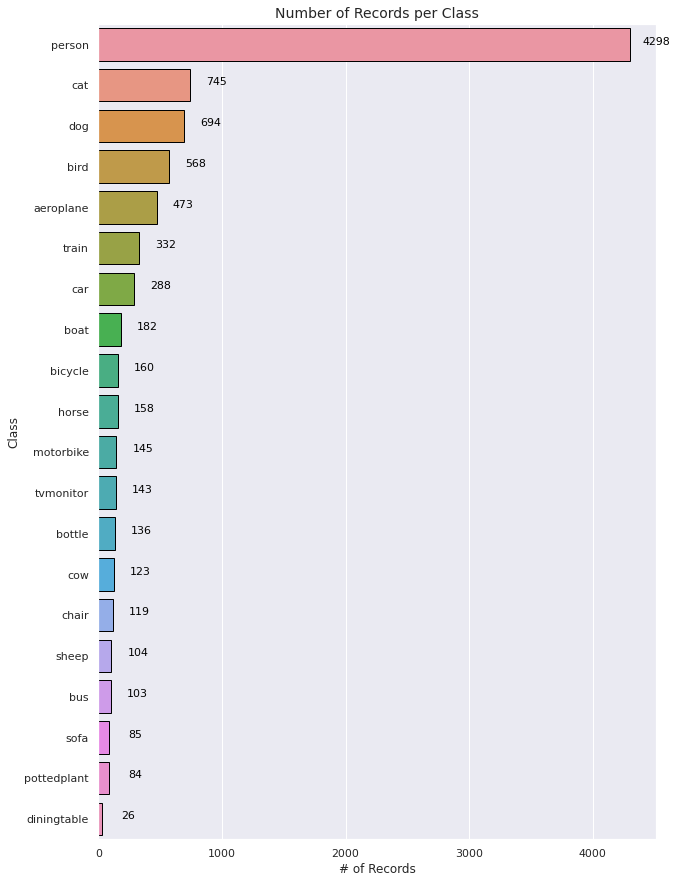

In [0]:
bar_plot(image_df, record_col, target_col)

## ***Data Preparation***

In [0]:
# Selecting only cats, dogs and birds classes
sample_classes = ['bird', 'cat', 'dog']
sample_df = image_df[image_df['Class_Name'].isin(sample_classes)].copy().reset_index(drop=True)

In [0]:
sample_class_map = {key: val + 1 for val, key in enumerate(sample_classes)}
sample_class_map['background'] = 0
inv_sample_class_map = {val: key for key, val in sample_class_map.items()}

In [0]:
sample_df['Class_ID'] = sample_df['Class_Name'].map(sample_class_map)

In [0]:
sample_df.head().T

,0,1,2,3,4
Name,2010_002688,2009_003640,2010_003015,2010_005134,2008_000559
Width,500,500,500,500,500
Height,210,388,333,451,375
Object_Qty,1,1,1,1,1
Image_Path,data/images/VOCdevkit/VOC2012/JPEGImages/2010_...,data/images/VOCdevkit/VOC2012/JPEGImages/2009_...,data/images/VOCdevkit/VOC2012/JPEGImages/2010_...,data/images/VOCdevkit/VOC2012/JPEGImages/2010_...,data/images/VOCdevkit/VOC2012/JPEGImages/2008_...
Class_ID,1,1,1,3,3
Class_Name,bird,bird,bird,dog,dog
xmin,303,90,130,71,0
ymin,87,95,48,9,0
xmax,450,359,487,499,499


###***Data Split - Train/Validation***

In [0]:
def data_split(data, save_data=True, load_data=True):
    # Data split part
    train_data, testval_data = train_test_split(data, test_size=0.2, random_state=10, stratify=data[target_col])
    val_data, test_data = train_test_split(testval_data, test_size=0.5, random_state=10, stratify=testval_data[target_col])

    # Setting variables
    file_contents = [train_data, val_data, test_data]
    file_names = ['train_data.csv', 'val_data.csv', 'test_data.csv']

    # Reseting indices on data
    for contents in file_contents:
        contents.reset_index(drop=True, inplace=True)

    # Saving data to csv files
    if save_data:
        for name, contents in zip(file_names, file_contents):
            contents.to_csv(path_or_buf=DATA_DIR/name, index=False, header=True)
    
    # Loading data from csv files
    if load_data:
        for name, contents in zip(file_names, file_contents):
            contents = pd.read_csv(DATA_DIR/name, low_memory=False)
    
    return train_data, val_data, test_data

In [0]:
target_col = 'Class_ID'
image_path_col = 'Image_Path'
bndbox_cols = ['ymin_pct', 'xmin_pct', 'ymax_pct', 'xmax_pct']

work_data = sample_df.copy()

In [0]:
# Spliting data into train, validation and test sets
train_data, val_data, test_data = data_split(work_data)

In [0]:
# Checking the shapes of splited data
[x.shape for x in (train_data, val_data, test_data)]

[(1605, 17), (201, 17), (201, 17)]

In [0]:
train_data.head().T

,0,1,2,3,4
Name,2010_005561,2008_006566,2008_001414,2011_001971,2009_002831
Width,500,500,500,375,500
Height,375,375,416,500,334
Object_Qty,1,1,1,1,1
Image_Path,data/images/VOCdevkit/VOC2012/JPEGImages/2010_...,data/images/VOCdevkit/VOC2012/JPEGImages/2008_...,data/images/VOCdevkit/VOC2012/JPEGImages/2008_...,data/images/VOCdevkit/VOC2012/JPEGImages/2011_...,data/images/VOCdevkit/VOC2012/JPEGImages/2009_...
Class_ID,3,1,2,2,1
Class_Name,dog,bird,cat,cat,bird
xmin,160,231,56,0,134
ymin,15,141,30,90,100
xmax,347,371,481,336,398


In [0]:
n_categories = train_data[target_col].nunique() + 1
n_categories

4

### ***Dataset Creation***

In [0]:
def image_parse(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=IMG_CHANNELS)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)

    return image

In [0]:
def image_resize(image, img_dims):
    image = tf.image.resize(image, img_dims)
    
    return image

In [0]:
def image_augment(image, level=0):
    if level > 0:
        if level > 5:
            level = 5
        
        delta = 0.1 * level
        lower = 1 - delta
        upper = 1 + delta
        image = tf.image.random_contrast(image, lower=lower, upper=upper)
        image = tf.image.random_saturation(image, lower=lower, upper=upper)
        image = tf.image.random_brightness(image, max_delta=delta)
        image = tf.image.random_hue(image, max_delta=delta)
        image = tf.clip_by_value(image, 0.0, 1.0)

    return image

In [0]:
def prepare_ds(
    df,
    x,
    y,
    batch_size,
    image_size,
    image_aug_level,
    prefetch=1,
    shuffle=False,
    num_parallel_calls=1,
):
    filenames = np.array([f"{getattr(row, x)}" for row in df.itertuples()])
    labels = tuple(
        [
            tf.cast(df[y[0]].values, tf.float32),
            tf.cast(df[y[1]].values, tf.float32),
        ]
    )
    dataset_length = len(filenames)

    parse_fn = partial(image_parse)
    resize_fn = partial(image_resize, img_dims=(image_size, image_size))
    augment_fn = partial(image_augment, level=image_aug_level)

    image_ds = (
        tf.data.Dataset.from_tensor_slices(filenames)
        .map(parse_fn, num_parallel_calls=num_parallel_calls)
        .map(resize_fn, num_parallel_calls=num_parallel_calls)
        .map(augment_fn, num_parallel_calls=num_parallel_calls)
     )
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    
    dataset = tf.data.Dataset.zip((image_ds, label_ds))

    if shuffle:
        dataset = dataset.shuffle(dataset_length)

    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat()
    if prefetch:
        dataset = dataset.prefetch(prefetch)
    return dataset, dataset_length, batch_size

In [0]:
BATCH_SIZE = 32
IMG_SIZE = 299
IMG_CHANNELS = 3
IMG_AUG_LEVEL = 3

In [0]:
train_dataset, train_dataset_length, train_batch_size = prepare_ds(
    df=train_data,
    x=image_path_col,
    y=[target_col, bndbox_cols],
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    image_aug_level=IMG_AUG_LEVEL,
    shuffle=True,
    prefetch=1,
    num_parallel_calls=-1,
)
train_dataset_steps = math.ceil(train_dataset_length / train_batch_size)

In [0]:
train_dataset.element_spec

(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None),
 (TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)))

In [0]:
def plot_dataset(dataset, rows, cols):
    _, ax = plt.subplots(rows, cols, figsize=(8 * cols, 8 * rows))
    colors = np.array([[1.0, 0.0, 0.0]])
    for i, (x, y) in enumerate(dataset.take(rows * cols)):
        categories, bounding_boxes = y
        images = tf.image.draw_bounding_boxes(x, tf.expand_dims(bounding_boxes, 1), colors)
        category = categories[0].numpy()
        bounding_box = bounding_boxes[0].numpy()
        ax[i // cols, i % cols].text(
            bounding_box[1] * IMG_SIZE,
            bounding_box[2] * IMG_SIZE,
            inv_sample_class_map[category].title(),
            backgroundcolor='red',
            fontsize=12,
        )
        ax[i // cols, i % cols].axis('off')
        title = f'Class - {category} ({inv_sample_class_map[category]})\n Box - {bounding_box[1]:.2}, {bounding_box[0]:.2}, {bounding_box[3]:.2}, {bounding_box[2]:.2}'
        ax[i // cols, i % cols].set_title(title)
        ax[i // cols, i % cols].imshow(images[0])

In [0]:
plot_dataset(train_dataset, 5, 3)

In [0]:
val_dataset, val_dataset_length, val_batch_size = prepare_ds(
    df=val_data,
    x=image_path_col,
    y=[target_col, bndbox_cols],
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    image_aug_level=0,
    shuffle=False,
    prefetch=1,
    num_parallel_calls=-1,
)
val_dataset_steps = math.ceil(val_dataset_length / val_batch_size)

## ***Building Model***

### ***Utilities & Setup***

In [0]:
def plot_history(history, contains, skip=0):
    _, ax = plt.subplots(1, len(contains), figsize=(20, 5))

    df = pd.DataFrame(history.history)
    for idx, item in enumerate(contains):
        ax[idx].plot(df[list(df.filter(regex=item))].iloc[skip:])
        ax[idx].set_title(item)

In [0]:
def model_capture(model, name, history, save_model=True, load_model=True):
    name = name.strip().replace(' ', '_').lower()
    architecture_path = str(Path(MODEL_DIR/f'{name}_weights.h5'))
    weights_path = str(Path(MODEL_DIR/f'{name}_arch.json'))
    history_path = str(Path(MODEL_DIR/f'{name}_hist.csv'))

    # Saving model weights and architecture into the files
    if save_model:
        model.save_weights(weights_path)
        with open(architecture_path, "w") as f:
            f.write(model.to_json())
        
        pd.DataFrame(history.history).to_csv(path_or_buf=history_path, index=False, header=True)
    
    # Loading model weights and architecture from the files
    if load_model:
        with open(architecture_path, "r") as f:
            model = keras.models.model_from_json(f.read())
        model.load_weights(weights_path)
    
    return model

In [0]:
IMG_DIMS = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
DROPOUT = 0.2
LEARN_RATE = 3e-4
L1_RATE = 1e-5
L2_RATE = 1e-6

EPOCHS = 100
PATIENCE = min(max(EPOCHS // 10, 3), 5)

In [0]:
callbacks=[
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=PATIENCE),
    tf.keras.callbacks.EarlyStopping(patience=int(PATIENCE * 2.5), restore_best_weights=True),
    tf.keras.callbacks.TerminateOnNaN(),
]

### ***Object Detection & Localization Model***

In [0]:
def make_model(img_dims, dropout, n_classes, l1, l2):
    model_input = keras.layers.Input(shape=img_dims)
    base = tf.keras.applications.Xception(include_top=False, weights='imagenet')(model_input)
    
    x0 = tf.keras.layers.concatenate([
                tf.keras.layers.GlobalAvgPool2D()(base),
                tf.keras.layers.GlobalMaxPool2D()(base),
    ])
    x0 = tf.keras.layers.BatchNormalization()(x0)
    x0 = tf.keras.layers.Dropout(dropout)(x0)

    class_x1 = tf.keras.layers.Dense(
        1024,
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.he_uniform(),
    )(x0)
    class_x1 = tf.keras.layers.BatchNormalization()(class_x1)
    class_x1 = tf.keras.layers.Dropout(dropout * 2)(class_x1)

    class_x2 = tf.keras.layers.Dense(
        512,
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.he_uniform(),
    )(class_x1)
    class_x2 = tf.keras.layers.BatchNormalization()(class_x2)
    class_x2 = tf.keras.layers.Dropout(dropout * 2)(class_x2)

    class_x3 = tf.keras.layers.Dense(
        256,
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.he_uniform(),
    )(class_x2)
    class_x3 = tf.keras.layers.BatchNormalization()(class_x3)
    class_x3 = tf.keras.layers.Dropout(dropout * 2)(class_x3)

    category = tf.keras.layers.Dense(
        n_classes,
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1, l2),
        activation=tf.keras.activations.softmax,
        name='class',
    )(class_x3)

    box_x1 = tf.keras.layers.Dense(
        1024,
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.he_uniform(),
    )(x0)
    box_x1 = tf.keras.layers.BatchNormalization()(box_x1)
    box_x1 = tf.keras.layers.Dropout(dropout)(box_x1)

    box_x2 = tf.keras.layers.Dense(
        512,
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.he_uniform(),
    )(box_x1)
    box_x2 = tf.keras.layers.BatchNormalization()(box_x2)
    box_x2 = tf.keras.layers.Dropout(dropout)(box_x2)

    box_x3 = tf.keras.layers.Dense(
        256,
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.he_uniform(),
    )(box_x2)
    box_x3 = tf.keras.layers.BatchNormalization()(box_x3)
    box_x3 = tf.keras.layers.Dropout(dropout)(box_x3)

    bounding_box = tf.keras.layers.Dense(
        4,
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1 / 10, l2 / 10),
        activation=tf.keras.activations.sigmoid,
        name='bound_box'
    )(box_x3)
    model = keras.Model(inputs=model_input, outputs=[category, bounding_box])

    return model

In [0]:
model = make_model(
    img_dims=IMG_DIMS,
    dropout=DROPOUT,
    n_classes=n_categories,
    l1=L1_RATE,
    l2=L2_RATE,
)
model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
xception (Model)                multiple             20861480    input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           xception[1][0]                   
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 2048)         0           xception[1][0]                   
_____________________________

In [0]:
class IntersectionOverUnion(tf.keras.metrics.Metric):

    def __init__(self, name='intersection_over_union', **kwargs):
        super(IntersectionOverUnion, self).__init__(name=name, **kwargs)
        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.iou_sum = self.add_weight(name='iou_sum', initializer='zeros')
        self.iou_cnt = self.add_weight(name='iou_cnt', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_min_true = y_true[:, 0]
        x_min_true = y_true[:, 1]
        y_max_true = y_true[:, 2]
        x_max_true = y_true[:, 3]
        width_true = tf.subtract(x_max_true, x_min_true)
        height_true = tf.subtract(y_max_true, y_min_true)

        y_min_pred = y_pred[:, 0]
        x_min_pred = y_pred[:, 1]
        y_max_pred = y_pred[:, 2]
        x_max_pred = y_pred[:, 3]
        width_pred = tf.subtract(x_max_pred, x_min_pred)
        height_pred = tf.subtract(y_max_pred, y_min_pred)

        x_min_inter = tf.maximum(x_min_true, x_min_pred)
        x_max_inter = tf.minimum(x_max_true, x_max_pred)
        y_min_inter = tf.maximum(y_min_true, y_min_pred)
        y_max_inter = tf.minimum(y_max_true, y_max_pred)
        width_inter = tf.subtract(x_max_inter, x_min_inter)
        height_inter = tf.subtract(y_max_inter, y_min_inter)
        width_inter = tf.multiply(width_inter, tf.cast((width_inter > 0), dtype='float32'))
        height_inter = tf. multiply(height_inter, tf.cast((height_inter > 0), dtype='float32'))

        intersection = tf.multiply(width_inter, height_inter)
        union = tf.subtract(tf.add(tf.multiply(width_true, height_true), tf.multiply(width_pred, height_pred)), intersection)
        metric = tf.divide(intersection, union)

        self.iou_sum.assign_add(tf.reduce_mean(metric))
        self.iou_cnt.assign_add(1.)
        self.iou.assign(self.iou_sum / self.iou_cnt)

    def result(self):
      return self.iou

    def reset_states(self):
      # The state of the metric will be reset at the start of each epoch.
      self.iou.assign(0.)
      self.iou_cnt.assign(0.)
      self.iou_sum.assign(0.)

In [0]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(LEARN_RATE),
    loss=[
        tf.keras.losses.SparseCategoricalCrossentropy(),
        tf.keras.losses.BinaryCrossentropy(),
    ],
    loss_weights=[0.01, 1.0],
    metrics=[
        [tf.keras.metrics.SparseCategoricalAccuracy()],
        [IntersectionOverUnion()],
    ],
)

In [0]:
model_history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=val_dataset,
    validation_steps=val_dataset_steps,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/100
51/51 [==============================] - 40s 789ms/step - loss: 0.8479 - class_loss: 0.7723 - bound_box_loss: 0.8393 - class_sparse_categorical_accuracy: 0.7383 - bound_box_intersection_over_union: 0.0559 - val_loss: 1.0157 - val_class_loss: 0.3959 - val_bound_box_loss: 1.0109 - val_class_sparse_categorical_accuracy: 0.8856 - val_bound_box_intersection_over_union: 0.0020 - lr: 3.0000e-04
Epoch 2/100
51/51 [==============================] - 37s 729ms/step - loss: 0.7363 - class_loss: 0.4491 - bound_box_loss: 0.7310 - class_sparse_categorical_accuracy: 0.8598 - bound_box_intersection_over_union: 0.0648 - val_loss: 0.7063 - val_class_loss: 0.3079 - val_bound_box_loss: 0.7024 - val_class_sparse_categorical_accuracy: 0.9005 - val_bound_box_intersection_over_union: 0.0220 - lr: 3.0000e-04
Epoch 3/100
51/51 [==============================] - 37s 732ms/step - loss: 0.6741 - class_loss: 0.3844 - bound_box_loss: 0.6694 - class_sparse_categorical_accuracy: 0.8885 - bound_box_intersect

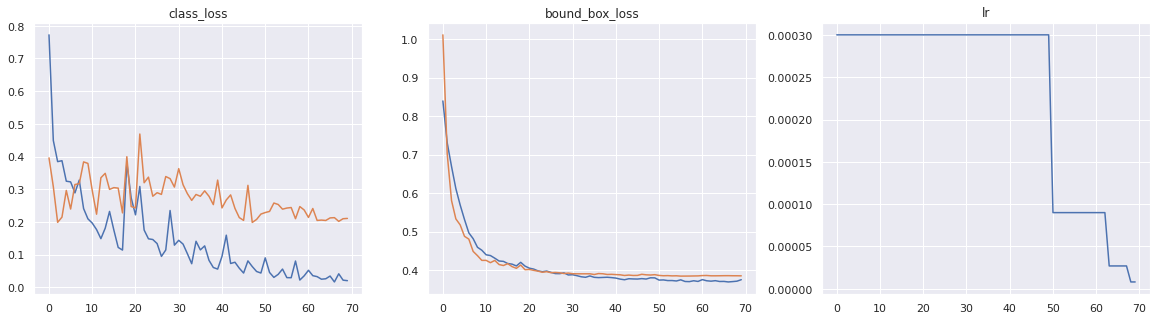

In [0]:
plot_history(model_history, ['class_loss', 'bound_box_loss', 'lr'])

In [0]:
model.evaluate(val_dataset, steps=val_dataset_steps)

7/7 [==============================] - 1s 108ms/step - loss: 0.3876 - class_loss: 0.2099 - bound_box_loss: 0.3850 - class_sparse_categorical_accuracy: 0.9403 - bound_box_intersection_over_union: 0.7158


[0.38762161135673523,
 0.20987556874752045,
 0.38500386476516724,
 0.9402984976768494,
 0.7157992124557495]

In [0]:
model_name = 'Object Location'
model_hist_file = f'{model_name.strip().replace(" ", "_").lower()}_hist.csv'
loaded_model = model_capture(model, model_name, model_history)

In [0]:
loaded_model.compile(
    optimizer=tf.keras.optimizers.Adam(LEARN_RATE),
    loss=[
        tf.keras.losses.SparseCategoricalCrossentropy(),
        tf.keras.losses.BinaryCrossentropy(),
    ],
    loss_weights=[0.1, 1.0],
    metrics=[
        [tf.keras.metrics.SparseCategoricalAccuracy()],
        [IntersectionOverUnion()],
    ],
)

In [0]:
loaded_model.evaluate(val_dataset, steps=val_dataset_steps)

7/7 [==============================] - 1s 110ms/step - loss: 0.4065 - class_loss: 0.2099 - bound_box_loss: 0.3850 - class_sparse_categorical_accuracy: 0.9403 - bound_box_intersection_over_union: 0.7158


[0.4065103828907013,
 0.20987556874752045,
 0.38500386476516724,
 0.9402984976768494,
 0.7157992124557495]

In [0]:
def plot_predict_dataset(model, dataset, steps, rows, cols):
    _, ax = plt.subplots(rows, cols, figsize=(8 * cols, 8 * rows))
    red_color = np.array([[1.0, 0.0, 0.0]])
    blue_color = np.array([[0.0, 0.0, 1.0]])
    for i, (x, y) in enumerate(dataset.take(rows * cols)):
        categories_t, bounding_boxes_t = y
        category_t = categories_t[0].numpy()
        bounding_box_t = bounding_boxes_t[0].numpy()

        categories_p, bounding_boxes_p = model.predict(x)
        category_p = categories_p[0].argmax()
        bounding_box_p = bounding_boxes_p[0]

        images = tf.image.draw_bounding_boxes(x, tf.expand_dims(bounding_boxes_t, 1), red_color)
        images = tf.image.draw_bounding_boxes(images, tf.expand_dims(bounding_boxes_p, 1), blue_color)

        ax[i // cols, i % cols].text(
            bounding_box_t[1] * IMG_SIZE,
            bounding_box_t[0] * IMG_SIZE,
            inv_sample_class_map[category_t].title(),
            backgroundcolor='red',
            fontsize=12,
        )

        ax[i // cols, i % cols].text(
            bounding_box_p[1] * IMG_SIZE,
            bounding_box_p[2] * IMG_SIZE,
            inv_sample_class_map[category_p].title(),
            color='white',
            backgroundcolor='blue',
            fontsize=12,
        )

        ax[i // cols, i % cols].axis('off')
        title_true = f'True: Class - {category_t} ({inv_sample_class_map[category_t]})\n Red Box - {bounding_box_t[1]:.2}, {bounding_box_t[0]:.2}, {bounding_box_t[3]:.2}, {bounding_box_t[2]:.2}'
        title_pred = f'Pred: Class - {category_p} ({inv_sample_class_map[category_p]})\n Blue Box - {bounding_box_p[1]:.2}, {bounding_box_p[0]:.2}, {bounding_box_p[3]:.2}, {bounding_box_p[2]:.2}'
        ax[i // cols, i % cols].set_title(title_true + '\n' + title_pred)
        ax[i // cols, i % cols].imshow(images[0])

In [0]:
plot_predict_dataset(loaded_model, val_dataset, val_dataset_steps, 4, 4)

## ***The End***